# Schrödingerization matrix operations test

Validate the **Schrödingerization construction** used in the thesis by comparing:

- I) The *classical* propagator  $\Phi(T)=\exp(CT)$ for the PMP Hamiltonian generator $C$
- II) The *reconstructed block* extracted from the Schrödingerized **unitary** $U_{\mathrm{Sch}}(T)$.

We use the **vehicle-platooning LQR benchmark** 

### Imports

In [1]:
import numpy as np
from pathlib import Path
import zipfile
from scipy.linalg import expm, norm
import matplotlib.pyplot as plt


from utils.export import *
from models.vehicle_platoon import make_vehicle_platoon
from utils.schroding import *

### Output saving settings

In [2]:
run_name = "Sch"  # used for filenames

ROOT = find_repo_root()
FIG_DIR, RES_DIR = ensure_out_dirs(ROOT)
print("Repo root:", ROOT)

run_id = make_run_id(run_name)
print("Run id:", run_id)

generated_files: list[Path] = []

Repo root: C:\Users\CristinaÁlvarezYuste\OneDrive - Quantum Mads\Documentos\GitHub\Quantum-assisted-Optimal-Control-examples
Run id: Sch_20260121_114316_373546


## 1) Vehicle platooning example

### Editable parameters

In [3]:
# --- Type of instance ---
MODEL_NAME = "vehicle_platoon"     

# --- Time horizon and grid ---
T = 10.0
dt = 0.001

# --- Physical and model parameters ---
n   =  2           # number of followers
d   = 5.0          # desired spacing [m]
d0  = 60.0         # initial spacing [m]
tau = 0.5          # actuator lag [s]

# ----------------- Single vehicle model ----------------
A0 = np.array([[0.0, 1.0,      0.0],
               [0.0, 0.0,      1.0],
               [0.0, 0.0, -1.0/tau]], dtype=float)  # (3x3)

b0 = np.array([[0.0],
               [0.0],
               [1.0/tau]], dtype=float)             # (3x1)

# LQR weights (per-vehicle)
Q0 = np.diag([1.0, 1.0, 1.0])   # on [spacing error, rel speed, rel accel]
R0 = np.array([[0.5]])          # scalar input weight (control effort)
# Terminal weight (stacked n-followers)
H = np.eye(3*n)

# ----------------- Stacked n-followers model --------------
# initial absolute states (leader + n followers)  length = n+1
s0 = 300.0
v0 = 7.0

s_abs = s0 - np.arange(0, n+1) * d0      # [s0, s0-d0, s0-2d0, ...]
v_abs = np.full(n+1, v0)
a_abs = np.zeros(n+1)

# ----------------- Leader dynamics (exogenous) ------------------
def u0(t): 
    u0 = 20* np.sin(2*t)                  # leader input can be time dependent!
    return u0               


# Choose a propagation time
DeltaT = 0.2


# --- Output controls ---
save_plots = False
save_results = False
make_zip = False


In [4]:
model = make_vehicle_platoon(n=n, d=d, tau=tau, T=T, dt=dt, s_abs=s_abs, v_abs=v_abs, a_abs=a_abs, Q0=Q0, R0=R0, H=H, u0=u0, integrate_leader=True)
dim = model.C.shape[0] 
print("Created", model.name, "with dim =", model.A.shape[0])
print("dim(z) =", dim, " (expected 2*3N_followers =", 2*3*n, ")")

Created vehicle_platoon with dim = 6
dim(z) = 12  (expected 2*3N_followers = 12 )


## 1.1) Schrödingerization construction (unitary $U_{Sch}$)
We want to reproduce the (generally non-unitary) linear flow
$$
\dot z(t)=C z(t), \qquad z(\Delta T)=\Phi(\Delta T)z(0), \quad \Phi(\Delta T)=e^{C\Delta T},
$$
by embedding it into a unitary evolution on an enlarged Hilbert space using the **Schrödingerization** technique. 


#### 1.1.1) Hermitian decomposition of the generator
We write
$$
C = C_1 + i C_2, \qquad 
C_1 := \frac{C+C^\dagger}{2}, \qquad 
C_2 := \frac{C-C^\dagger}{2i},
$$
so that both $C_1$ and $C_2$ are Hermitian. 


In [5]:
# Hermitian decomposition C = C1 + i C2 with C1,C2 Hermitian
C1 = (model.C + model.C.T.conj())/2
C2 = (model.C - model.C.T.conj())/2j

#### 1.1.2) Auxiliary register and window parameter $R_\xi$
We introduce an auxiliary register of size $n_\xi$ qubits, with dimension
$$
N_\xi = 2^{n_\xi}.
$$
The auxiliary degree of freedom originates from a **warped phase** variable $\xi$ and one works in its Fourier-conjugate variable $\eta$. 

Practically, we truncate the auxiliary domain to a finite window and discretise it; the window size is controlled by $R_\xi$ so that the warped initial state is negligible at the boundaries (to avoid periodic wrap-around when using Fourier methods). 

We build a discrete grid $\{\xi_k\}$ on $[ -R_\xi\pi,\; R_\xi\pi)$ with spacing
$$
N_\xi = 2^{n_\xi}, \qquad \Delta \xi = \frac{2R_\xi\pi}{N_\xi}
$$
$$
\xi_k = -R_\xi\pi + k\Delta\xi, \qquad k = 0, \dots, N_\xi -1
$$


#### 1.1.3) Window state \(|p\rangle\) and state preparation
Define the **order-1** envelope
$$
f(\xi)=e^{-|\xi|}.
$$

For **order-2**, we replace $e^{-|\xi|}$ on the interval $(-1,0)$ by a cubic polynomial to make the profile smoother as it improves convergence of the Fourier/spectral discretisation ("initial_schro_fp"):

$
f_2(\xi)=
\begin{cases}
e^{-|\xi|}, & \xi\notin(-1,0) \\
\left(\frac{3}{e}-3\right)\xi^3 + \left(\frac{4}{e}-5\right)\xi^2 - \xi + 1, & -1<\xi<0.
\end{cases}
$

Then we discretise and normalise:
$$
v_k := f_2(\xi_k),\qquad
||v||_2=\left(\sum_{k=0}^{N_\xi-1}||v_k||^2\right)^{1/2},\qquad
p_k := \frac{v_k}{||v||_2}.
$$

Finally, the auxiliary state prepared in the computational basis ${|\xi_k\rangle}$ is
$$
|p\rangle=\sum_{k=0}^{N_\xi-1} p_k|\xi_k\rangle,
\qquad \langle p|p\rangle = 1.
$$

And we then build a unitary $U_p$ such that $U_p|0\rangle = |p\rangle$.



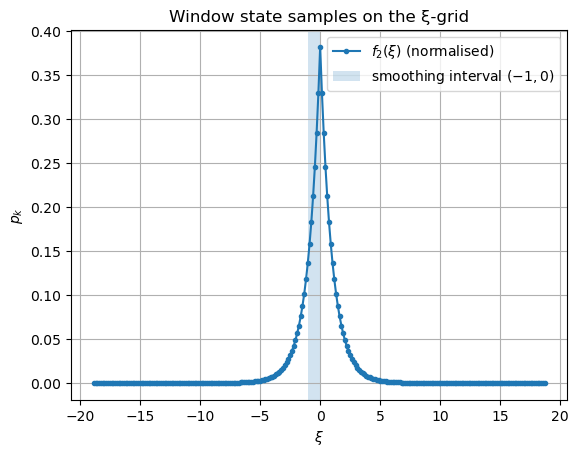

In [6]:
# --- Schrödingerization parameters ---
n_xi = 8                 # number of qubits for the aux variable 
N_xi = 2**n_xi           # size of xi-register 
R_xi = 6                 # window scaling


# p-grid and window state |p>
xi_grid  = np.arange(-R_xi * np.pi, R_xi * np.pi, step = 2 * R_xi * np.pi / N_xi)
xi_state = initial_schro_fp(xi_grid, 15)
xi_state_norm = np.linalg.norm(xi_state)
xi_state = xi_state / xi_state_norm

plt.figure()
plt.plot(xi_grid, xi_state, marker=".", linestyle="-", label=r"$f_2(\xi)$ (normalised)")
plt.axvspan(-1, 0, alpha=0.2, label=r"smoothing interval $(-1,0)$")
plt.xlabel(r"$\xi$")
plt.ylabel(r"$p_k$")
plt.title("Window state samples on the ξ-grid")
plt.grid(True)
plt.legend()
plt.show()

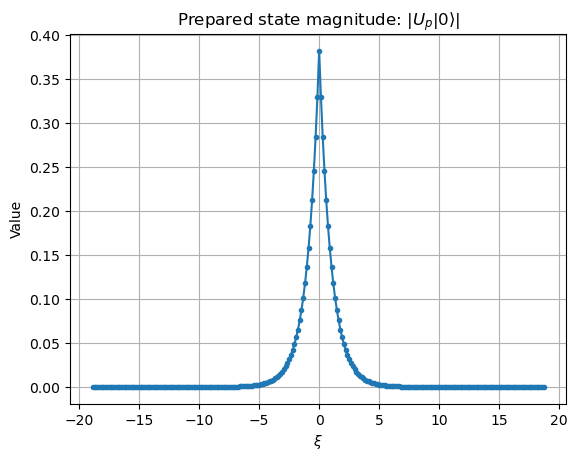

In [7]:
# state preparation unitary Up such that Up|0> = |p>
U_state_prep = gram_schmidt(xi_state)

xi_from_U = U_state_prep[:, 0]  # U_p |0> is the first column
plt.figure()
plt.plot(xi_grid,np.abs(xi_from_U), marker=".")
plt.title(r"Prepared state magnitude: $|U_p|0\rangle|$")
plt.xlabel(r"$\xi$")
plt.ylabel("Value")
plt.grid(True)
plt.show()


#### 1.1.4) QFT/IQFT on the auxiliary register
Let $F$ denote the discrete QFT mapping the $|\xi\rangle$-basis to the Fourier-mode basis $|\eta\rangle$:
$$
F|\xi_k\rangle = \frac{1}{\sqrt{N_p}}\sum_{j=0}^{N_p-1} e^{2\pi i jk/N_p}\,|\eta_j\rangle,
\qquad F^\dagger = \mathrm{IQFT}.
$$
The Schrödingerization circuit applies QFT, then simulates the embedded Hamiltonian, then applies IQFT. 


In [8]:
# QFT/IQFT on xi-register
QFT_matrix = qft_matrix(n_xi)
IQFT_matrix = iqft_matrix(n_xi)

#### 1.1.5) Discrete spectrum $\eta$ and embedded Hermitian Hamiltonian
We discretise the Fourier modes as **centred integers**,
$$
\eta_j = \frac{1}{R_\xi}\Bigl(j - \frac{N_\xi}{2}\Bigr), \qquad j=0,\dots,N_\xi-1,
$$
and define the diagonal operator
$$
D_\eta = \mathrm{diag}(\eta_0,\dots,\eta_{N_\xi-1}).
$$

The embedded Hermitian generator takes the structured form
$$
H_{\mathrm{emb}} = D_\eta \otimes C_1 \;+\; I_{N_\xi}\otimes C_2,
$$

With the auxiliary register first (Fourier modes) and system register second


In [9]:
# η spectrum (centered integers) scaled by 1/R_xi
eta = np.arange(N_xi)
eta[2**(n_xi-1):] -= N_xi
eta = eta / R_xi
diag_eta = np.diag(eta)

# Embedded Hermitian Hamiltonian for Schrödingerization
Hamiltonian = np.kron(diag_eta, C1) + np.kron(np.eye(N_xi), C2)


We inspect the real parts of the eigenvalues of the PMP generator $C$. 

If $ \alpha=\max_i \Re(\lambda_i(C))>0 $, then the flow $e^{CT}$ contains exponentially growing modes and long-horizon propagation becomes highly sensitive (heuristically $\|e^{CT}\|\sim e^{\alpha T}$). 

In [10]:
vals = np.linalg.eigvals(model.C)
print(vals.real)

[-3.37011069  3.37011069 -0.76172347 -0.76172347  0.76172347  0.76172347
 -3.37011069  3.37011069 -0.76172347 -0.76172347  0.76172347  0.76172347]



#### 1.1.6) Unitary evolution and full Schrödingerized unitary
Since $H_{\mathrm{emb}}$ is Hermitian, we can form the unitary
$$
U_H(\Delta T) = e^{\,i H_{\mathrm{emb}}\Delta T}.
$$
The full Schrödingerized unitary acting on **auxiliary ⊗ system** is then
$$
U_{\mathrm{sch}}
= (IQFT^\dagger\!\otimes I_d)\; U_H(\Delta T)\; (QFT\otimes I_d)\; (U_p\otimes I_d),
$$

In [11]:
# Unitary evolution on enlarged space
U_H = expm(-1j * Hamiltonian * DeltaT)

# Full Schrödingerized unitary (acts on η ⊗ system)
U_sch = np.kron(IQFT_matrix, np.eye(dim)) @ (U_H @ (np.kron(QFT_matrix, np.eye(dim)) @ np.kron(U_state_prep, np.eye(dim))))

print("U_sch shape:", U_sch.shape)

U_sch shape: (3072, 3072)


## 1.2) Classical reference propagator 

In [12]:
Phi = expm(-model.C * DeltaT)

## 1.3) Operator-level check: reconstruct $\exp(CT)$ from a block of $U_{\mathrm{sch}}$


#### 1.3.1) Picking an index $k$ with non-negligible envelope weight
We prepare a normalised auxiliary “window” state
$$
|p\rangle \;=\;\sum_{k=0}^{N_p-1} p_k\,|k\rangle,
\qquad \sum_{k=0}^{N_p-1}|p_k|^2=1,
$$
where in the code the coefficient vector is stored in `xi_state` (so **`xi_state[k]` corresponds to $p_k$**).

The reconstruction step divides by $p_k$, hence indices with very small $|p_k|$ are numerically unsafe because the division amplifies discretisation and floating-point errors. A simple heuristic is to start from the centered index,
$$
k_{0} = N_\xi/2,
$$
and probe neighbouring indices to study how reconstruction quality depends on the postselected auxiliary outcome $k$. This is particularly important when the Hermitian part $H_1$ has positive eigenvalues. In this case the recovery is only guaranteed in a right-hand region $\xi\ge \xi^\star$, where the warped-phase construction yields
$$
u_f(t)=e^{\xi}\,w(t,\xi)\qquad \text{for } \xi\ge \xi^\star,
$$
with the threshold
$$
\xi^\star=\lambda_{\max}^+(H_1)\,T,\qquad 
\lambda_{\max}^+(H_1):=\max\{0,\lambda_{\max}(H_1)\}.
$$
Hence, if $\lambda_{\max}(H_1)>0$ then $\xi^\star>0$ and decoding near the centre $\xi\approx 0$ is not theoretically supported and can exhibit larger errors. Offsetting the chosen index (for example by `+8`) moves the decoding point toward $p>0$, potentially closer to the recovery region, and serves as a simple diagnostic of this effect. 

chosen k = 136  |p[k]| = 0.11771793723924907


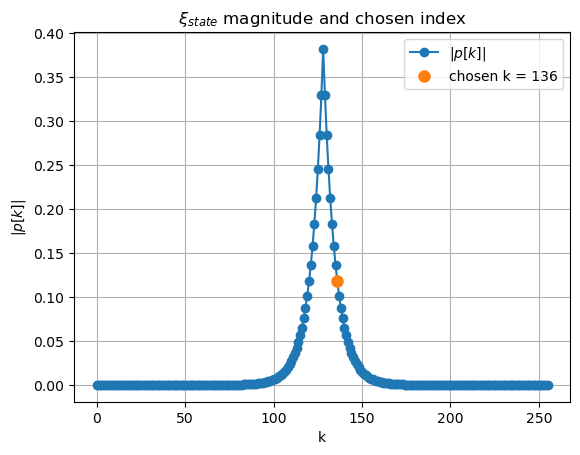

In [13]:
# Choose an index k where |p[k]| is not too small
k = N_xi//2 + 8
print("chosen k =", k, " |p[k]| =", abs(xi_state[k]))

x = np.arange(len(xi_state))
y = np.abs(xi_state)          # plot magnitude; switch to xi_state.real if you prefer

plt.figure()
plt.plot(x, y, marker="o", linestyle="-",label=r"$|p[k]|$")
plt.plot(k, y[k], "o", markersize=8, label=f"chosen k = {k}")
plt.xlabel("k")
plt.ylabel(r"$|p[k]|$")
plt.title(r"$\xi_{state}$ magnitude and chosen index")
plt.legend()
plt.grid(True)
plt.show()


#### 1.3.2) Block extraction from $U_{\mathrm{sch}}$
The Schrödingerized unitary acts on the enlarged space
$$
\mathcal{H}_{\text{aux}}\otimes\mathcal{H}_{\text{sys}},
\qquad \dim(\mathcal{H}_{\text{aux}})=N_{\xi},\quad \dim(\mathcal{H}_{\text{sys}})=d.
$$
So a full state is a stacked vector of length $N_\xi\cdot d$, each block being a $d$-dimensional system vector:
$$
\psi =
\begin{bmatrix}
\psi^{(0)}\\
\psi^{(1)}\\
\vdots\\
\psi^{(N_\xi-1)}
\end{bmatrix},
\qquad \psi^{(k)}\in\mathbb{C}^d.
$$

When you apply $U_{\mathrm{sch}}$ to an input of the form $|0\rangle\otimes z_0$, only the **first auxiliary block** is populated at the input. After applying $U_{\mathrm{sch}}$, the output has (in general) contributions in all auxiliary blocks.

The matrix $U_{\mathrm{sch}}\in\mathbb{C}^{(N_\xi d)\times (N_\xi d)}$ can therefore be viewed as an $N_\xi\times N_\xi$ matrix of **blocks**, where each block is $d\times d$:
$$
U_{\mathrm{sch}}=
\begin{bmatrix}
U_{00} & U_{01} & \cdots \\
U_{10} & U_{11} & \cdots \\
\vdots & \vdots & \ddots
\end{bmatrix},
\qquad U_{k\ell}\in\mathbb{C}^{d\times d}.
$$

- We focus on blocks $U_{k0}$ because the auxiliary register is initialised in $|0\rangle\otimes z_0$ hence only the $l=0$ input column of blocks contributes to the output.



In [14]:
# Extract block (k,0) of size d×d 
block_k0 = U_sch[k*dim:(k+1)*dim, 0*dim:(0+1)*dim]
Phi_hat = block_k0 / xi_state[k] 


#### 1.3.3) Reconstruction error (operator-level)

After decoding, we obtain a reconstructed propagator $\widehat\Phi_k$ and compare it with the exact matrix exponential $\Phi$.
As an operator-level accuracy metric we use the **relative Frobenius error**
$$
\mathrm{err}_F(k)
:=\frac{\|\widehat\Phi_k-\Phi\|_F}{\|\Phi\|_F},
\qquad 
\|A\|_F := \Bigl(\sum_{i,j}|A_{ij}|^2\Bigr)^{1/2}.
$$
This produces a single scalar measuring how close the reconstructed matrix is to the classical propagator.



In [15]:
# Compute relative error
rel_err = norm(Phi_hat - Phi, ord='fro') / norm(Phi, ord='fro')
print("Relative Frobenius error ||Phi_hat - Phi||_F / ||Phi||_F =", rel_err)

Relative Frobenius error ||Phi_hat - Phi||_F / ||Phi||_F = 0.010677557370142178


#### 1.3.4) Error vs. postselected index $k$

The reconstruction formula
$$
\widehat\Phi_k \;=\;\frac{1}{p_k}\,U_{k0}\ \approx\ \Phi(\Delta T)=e^{C\Delta T}
$$
depends on the chosen auxiliary outcome $k$. To study this dependence, we compute the operator-level
relative Frobenius error for **all** indices $k\in\{0,\dots,N_p-1\}$

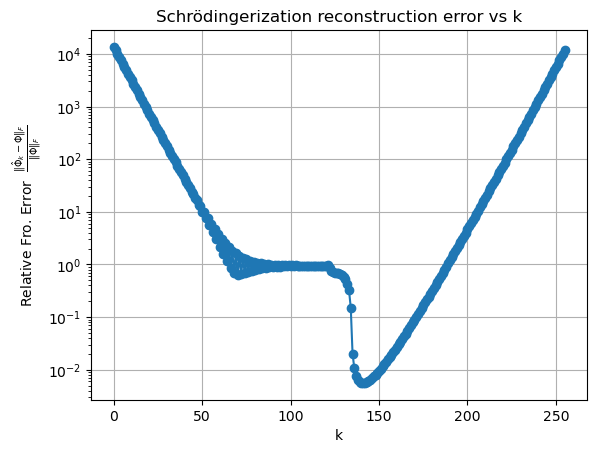

best k = 141  error = 0.005634308564600724  |p[k]| = 0.05637245329442989


In [16]:
errs = np.full(N_xi, np.nan, dtype=float)
pk_abs = np.abs(xi_state)

# threshold to avoid dividing by near zero coefficients p[k]
eps = 1e-12 * pk_abs.max()

for k in range(N_xi):
    if pk_abs[k] <= eps:
        continue

    block_k0 = U_sch[k*dim:(k+1)*dim, 0*dim:(0+1)*dim]
    Phi_hat_k = block_k0 / xi_state[k]
    errs[k] = norm(Phi_hat_k - Phi, ord='fro') / norm(Phi, ord='fro')

# Plot error vs k
plt.figure()
plt.plot(np.arange(N_xi), errs, marker="o", linestyle="-")
plt.xlabel("k")
plt.ylabel(r"Relative Fro. Error  $\frac{\|\hat\Phi_k-\Phi\|_F}{\|\Phi\|_F}$")
plt.yscale("log")
plt.title("Schrödingerization reconstruction error vs k")
plt.grid(True)
plt.show()

# Print best k (minimum error among valid ks)
valid = np.isfinite(errs)
k_best = int(np.nanargmin(errs))
print("best k =", k_best, " error =", errs[k_best], " |p[k]| =", pk_abs[k_best])

### *Same with another value for $\Delta T$*

In [17]:
# # Choose a propagation time
# DeltaT = 1.5


# U_H = expm(1j * Hamiltonian * DeltaT)
# U_sch = np.kron(IQFT_matrix, np.eye(dim)) @ (U_H @ (np.kron(QFT_matrix, np.eye(dim)) @ np.kron(U_state_prep, np.eye(dim))))
# Phi = expm(model.C * DeltaT)
# errs = np.full(N_xi, np.nan, dtype=float)
# for k in range(N_xi):
#     if pk_abs[k] <= eps:
#         continue

#     block_k0 = U_sch[k*dim:(k+1)*dim, 0*dim:(0+1)*dim]
#     Phi_hat_k = block_k0 / xi_state[k]
#     errs[k] = norm(Phi_hat_k - Phi, ord='fro') / norm(Phi, ord='fro')
# plt.figure()
# plt.plot(np.arange(N_xi), errs, marker="o", linestyle="-")
# plt.xlabel("k")
# plt.ylabel(r"Relative Fro. Error  $\frac{\|\hat\Phi_k-\Phi\|_F}{\|\Phi\|_F}$")
# plt.yscale("log")
# plt.title("Schrödingerization reconstruction error vs k")
# plt.grid(True)
# plt.show()
# valid = np.isfinite(errs)
# k_best = int(np.nanargmin(errs))
# print("best k =", k_best, " error =", errs[k_best], " |p[k]| =", pk_abs[k_best])    

In [18]:
# # Choose a propagation time
# DeltaT = 3


# U_H = expm(1j * Hamiltonian * DeltaT)
# U_sch = np.kron(IQFT_matrix, np.eye(dim)) @ (U_H @ (np.kron(QFT_matrix, np.eye(dim)) @ np.kron(U_state_prep, np.eye(dim))))
# Phi = expm(model.C * DeltaT)
# errs = np.full(N_xi, np.nan, dtype=float)
# for k in range(N_xi):
#     if pk_abs[k] <= eps:
#         continue

#     block_k0 = U_sch[k*dim:(k+1)*dim, 0*dim:(0+1)*dim]
#     Phi_hat_k = block_k0 / xi_state[k]
#     errs[k] = norm(Phi_hat_k - Phi, ord='fro') / norm(Phi, ord='fro')
# plt.figure()
# plt.plot(np.arange(N_xi), errs, marker="o", linestyle="-")
# plt.xlabel("k")
# plt.ylabel(r"Relative Fro. Error  $\frac{\|\hat\Phi_k-\Phi\|_F}{\|\Phi\|_F}$")
# plt.yscale("log")
# plt.title("Schrödingerization reconstruction error vs k")
# plt.grid(True)
# plt.show()
# valid = np.isfinite(errs)
# k_best = int(np.nanargmin(errs))
# print("best k =", k_best, " error =", errs[k_best], " |p[k]| =", pk_abs[k_best])    

## 1.4) State-level check: propagate a vector $z_0$ and compare $e^{C\Delta T}z_0$ vs. Schrödingerization decoding

So far we validated Schrödingerization at the **operator level** by reconstructing the full matrix
$\widehat\Phi_k \approx e^{C\Delta T}$. A complementary sanity check is to compare the **action on a vector**.

#### 1.4.1) Choose an initial condition in the system space
We pick an arbitrary (here: z0 yielded by DRE) initial condition $z_0\in\mathbb{C}^d$ and normalise it:
$$
z_0 \in \mathbb{C}^d,\qquad \|z_0\|_2=1.
$$
Normalisation is convenient because it makes postselection probabilities and relative errors well-scaled.


In [19]:
# Pick any initial condition z0 in the system space (dimension d)

z0 = np.array([-55, 0, 0, -110, 0, 0, -116.2, -95.2, -19.4, -232.3, -190.3, -38.9])
z0 = z0 / norm(z0)
print(z0)


[-0.15268507  0.          0.         -0.30537014  0.          0.
 -0.32258191 -0.26428398 -0.05385619 -0.64488621 -0.52829034 -0.10798999]


### 1.4.2) Classical propagation (reference $\Delta T=0.2$)
The classical (exact) time-$\Delta T$ propagation is
$$
z_T^{\text{class}} \;=\; \Phi(\Delta T)\,z_0
\;=\; e^{C\Delta T} z_0,
$$

In [20]:
# Reference \Delta T = 0.2 
DeltaT = 0.2
U_H = expm(1j * Hamiltonian * DeltaT)
U_sch = np.kron(IQFT_matrix, np.eye(dim)) @ (U_H @ (np.kron(QFT_matrix, np.eye(dim)) @ np.kron(U_state_prep, np.eye(dim))))
Phi = expm(model.C * DeltaT)
errs = np.full(N_xi, np.nan, dtype=float)
for k in range(N_xi):
    if pk_abs[k] <= eps:
        continue

    block_k0 = U_sch[k*dim:(k+1)*dim, 0*dim:(0+1)*dim]
    Phi_hat_k = block_k0 / xi_state[k]
    errs[k] = norm(Phi_hat_k - Phi, ord='fro') / norm(Phi, ord='fro')
valid = np.isfinite(errs)
k_best = int(np.nanargmin(errs))

# Classical propagation
zT_class = Phi @ z0

### 1.4.3) Schrödingerized propagation in the enlarged space

The Schrödingerized unitary $U_{\mathrm{sch}}$ acts on the enlarged vector space
$\mathbb{C}^{N_\xi}\otimes\mathbb{C}^{d}$.
We initialise the auxiliary register in the basis state $|0\rangle$ and the system in $z_0$:
$$
\psi_0 = |0\rangle\otimes z_0.
$$


After applying the unitary $ \psi_T = U_{\mathrm{sch}}\psi_0$, 
the resulting vector $\psi_T$ consists of $N_\xi$ consecutive system blocks of size $d$:
$$
\psi_T =
\begin{bmatrix}
\psi_T^{(0)}\\
\psi_T^{(1)}\\
\vdots\\
\psi_T^{(N_\xi-1)}
\end{bmatrix},
\qquad \psi_T^{(k)}\in\mathbb{C}^d.
$$


In [21]:
# Schrödingerized propagation: start from |0>_xi ⊗ z0
e0 = np.zeros(N_xi, dtype=complex)
e0[0] = 1.0
psi0 = np.kron(e0, z0)
psiT = U_sch @ psi0


### 1.4.4) Decoding the physical state from outcome $k$ and relative state error

Under the ideal block relation
$$
U_{k0}\approx p_k \Phi(\Delta T),
$$
the $k$-th output block satisfies
$$
\psi_T^{(k)} \approx p_k\Phi(\Delta T)z_0.
$$
Therefore we decode an estimate of the physical propagated state via
$$
\widehat z_T^{(k)}
:= \frac{1}{p_k}\psi_T^{(k)}
\approx \Phi(\Delta T)z_0.
$$
In the code we use $k=k_{\text{best}}$ (the index giving the smallest operator error among valid candidates),
extract the corresponding block, and divide by $p_{k_{\text{best}}}$.

Then report the relative state error
$$
\mathrm{err}_z
:=\frac{|\widehat z_T^{(k)}-z_T^{\text{class}}|_2}{|z_T^{\text{class}}|_2},
$$


In [22]:
# Decode the k block and rescale by p[k]
print('Reescaling factor p[k] =', xi_state[k_best])

zT_hat = psiT[k_best*dim:(k_best+1)*dim] / xi_state[k_best]

print("Relative state error ||zT_hat - zT_class|| / ||zT_class|| =", norm(zT_hat - zT_class) / norm(zT_class))

Reescaling factor p[k] = 0.05637245329442989
Relative state error ||zT_hat - zT_class|| / ||zT_class|| = 0.0021398074287817493



### 1.4.5) Component-wise plot

We plot the real parts of the components of $z_T$ to visually confirm agreement between:

* **Matrix exponential propagation** $z_T^{\text{class}}=e^{C\Delta T}z_0$,
* **Schrödingerized decoding** $\widehat z_T^{(k)}$.



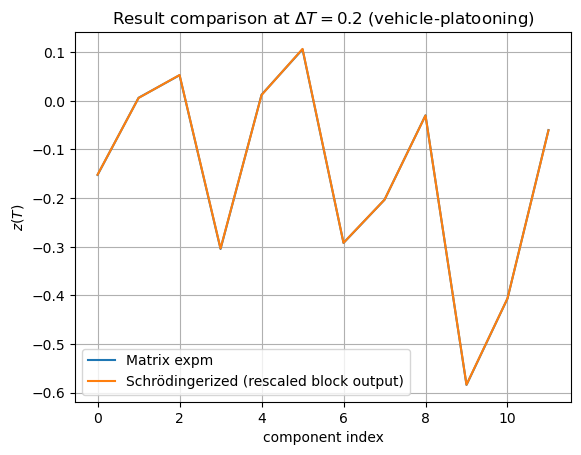

In [23]:
# --- Plot: component-wise comparison (real part) ---
idx = np.arange(dim)

plt.figure()
plt.plot(idx, zT_class.real, label="Matrix expm")
plt.plot(idx, zT_hat.real, label="Schrödingerized (rescaled block output)")
plt.xlabel("component index")
plt.ylabel(r"$z(T)$")
plt.title("Result comparison at $\Delta T={:.3g}$ (vehicle-platooning)".format(DeltaT))
plt.grid(True)
plt.legend()
plt.show()



### 1.5) Postselection probability and recovery index set $I^\star$ 

After applying the Schrödingerization circuit (QFT → controlled evolution → IQFT), we recover the target by **measuring the auxiliary register** in the computational basis. The measurement is
$$
M_k := |k\rangle\langle k|\otimes I,\qquad k\in\{0,\dots,N_\xi-1\},
$$
and the “good” outcomes are those in the recovery index set:
$$
I^\star := \{\,k:\ \xi_k \ge \xi^\star \,\},
$$
where $\xi_k$ denotes the auxiliary grid point associated with basis state $|k\rangle$. 

##### *Probability of observing outcome $k$*

Let the enlarged initial state be
$$
|\psi_0\rangle = |0\rangle_{\text{aux}}\otimes |z_0\rangle,\qquad \|z_0\|_2=1.
$$
After the unitary $U_{\mathrm{sch}}$,
$$
|\psi_T\rangle = U_{\mathrm{sch}}|\psi_0\rangle.
$$
The component associated with auxiliary outcome $k$ is obtained by projecting with $\langle k|\otimes I$:
$$
|\psi_T^{(k)}\rangle := (\langle k|\otimes I)\,|\psi_T\rangle \in \mathbb{C}^d.
$$
In block notation, this is exactly
$$
|\psi_T^{(k)}\rangle = U_{k0}\,z_0,
$$
where $U_{k0}\in\mathbb{C}^{d\times d}$ is the $(k,0)$ block of $U_{\mathrm{sch}}$.

Therefore, the Born-rule probability of measuring the auxiliary register in $|k\rangle$ is
$$
\boxed{\ \Pr(\text{aux}=k\mid z_0)=\|U_{k0}z_0\|_2^2\ }.
$$

Because $U_{\mathrm{sch}}$ is unitary and $\|\psi_0\|=1$, we have
$$
\sum_{k=0}^{N_\xi-1}\Pr(\text{aux}=k\mid z_0)=1,
$$
so plotting $\Pr(\text{aux}=k\mid z_0)$ over $k$ gives the **full postselection landscape**.


##### *Success probability* 

The probability of obtaining any “good” outcome is
$$
\boxed{\ \Pr(\text{recover}\mid z_0)=\sum_{k\in I^\star}\|U_{k0}z_0\|_2^2\ }.
$$
In "https://arxiv.org/pdf/2505.00370" is written as: $\Pr(w)=\sum_{k\in I^\star}\Pr(w(T,p_k))$. 



p_star = 0.9942082614546752 |I_star| = 121 out of 256
Sum_k probs[k] = 1.00000000000174
Pr(aux=k_best) = 0.002433127088124758

Success probability: Pr(recover) = sum_{k in I*} Pr(k) = 0.05593997960496792


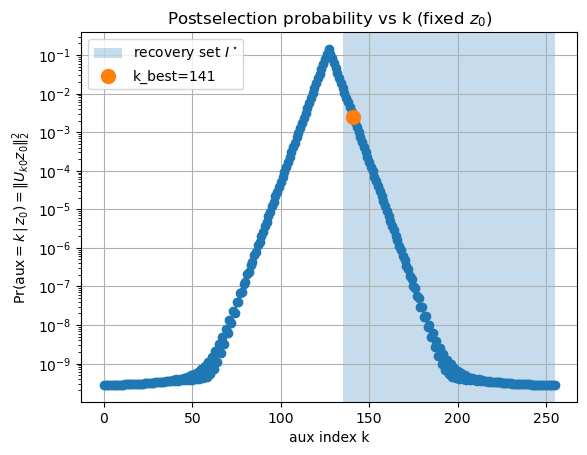

In [24]:
# --- Threshold xi* = lambda_max^+(C1) * DeltaT ---
lam_max = np.max(np.linalg.eigvalsh(C1))     # C1 Hermitian
p_star  = max(0.0, lam_max) * DeltaT

# Recovery indices: p_k >= p_star
# dp = xi_grid[1] - xi_grid[0]
# margin = 105 * dp
# I_star = np.where((xi_grid >= p_star) & (xi_grid <= xi_grid.max() - margin))[0]
I_star = np.where(xi_grid >= p_star)[0]
print("p_star =", p_star, "|I_star| =", len(I_star), "out of", N_xi)

# ---  Exact measurement probabilities Pr(aux=k | z0) = ||U_{k0} z0||^2 ---
# (Input auxiliary is |0>, so we take columns :dim which correspond to aux input 0)
probs = np.array([norm(U_sch[j*dim:(j+1)*dim, :dim] @ z0)**2 for j in range(N_xi)])
print("Sum_k probs[k] =", probs.sum())  # should be ~1 (unitarity, ||psi0||=1)
# Single-k probability (for your chosen k_best)
k = k_best
U_k0 = U_sch[k*dim:(k+1)*dim, :dim]
prob_k = norm(U_k0 @ z0)**2
print("Pr(aux=k_best) =", prob_k)

# --- Success probability: sum over recovery set I_star ---
prob_recover = probs[I_star].sum()
print("\nSuccess probability: Pr(recover) = sum_{k in I*} Pr(k) =", prob_recover)


# --- Plot distribution over k ---
import matplotlib.pyplot as plt

plt.figure()
plt.plot(probs, marker="o", linestyle="-")
if len(I_star) > 0:
    plt.axvspan(I_star.min(), I_star.max(), alpha=0.25, label=r"recovery set $I^\star$")
plt.plot(k_best, probs[k_best], "o", markersize=10, label=f"k_best={k_best}")
plt.title("Postselection probability vs k (fixed $z_0$)")
plt.xlabel("aux index k")
plt.ylabel(r"$\Pr(\mathrm{aux}=k\,|\,z_0)=\|U_{k0}z_0\|_2^2$")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()


#### Predicted success probability

The total recovery (postselection) probability can be viewed as a product of two terms:
$$
\Pr(\text{recover}) \approx \frac{C_{e0}^2}{C_e^2}\;\frac{\|u_f(T)\|^2}{\|u_I\|^2}.
$$
In our discretised setting, the window coefficients are normalised, so the ratio $\tfrac{C_{e0}^2}{C_e^2}$ becomes simply the total probability mass of the window over the recovery index set $I^\star$:
$$
\frac{C_{e0}^2}{C_e^2}=\sum_{k\in I^\star}|p_k|^2.
$$


The second factor is the norm growth of the physical evolution:
$$
\frac{\|u_f(T)\|_2^2}{\|u_I\|_2^2},
$$
where in our linear test we identify $u_I=z_0$ and $u_f(T)=\Phi z_0$ with $\Phi=e^{C\Delta T}$.



In [25]:
# --- Prefactor Ce0^2 / Ce^2 using NORMALISED coefficients xi_k ---
Ce_ratio = np.sum(np.abs(xi_state[I_star])**2)   # equals Ce0^2 / Ce^2
print("Ce0^2/Ce^2 =", Ce_ratio)

# --- norm ratio ||u_f(T)||^2 / ||u_I||^2 (here u_f(T)=Phi z0, u_I=z0) ---
uT = Phi @ z0
norm_ratio = (norm(uT)**2) / (norm(z0)**2)
print("||u_f(T)||^2 / ||u_I||^2 =", norm_ratio)

Pr_pred = Ce_ratio * norm_ratio


print("\nPredicted success probability: Pr(recover) ~ Ce0^2/Ce^2 * ||u_f(T)||^2 / ||u_I||^2 =", Pr_pred)



Ce0^2/Ce^2 = 0.07292240783356256
||u_f(T)||^2 / ||u_I||^2 = 0.7671554635718314

Predicted success probability: Pr(recover) ~ Ce0^2/Ce^2 * ||u_f(T)||^2 / ||u_I||^2 = 0.055942823586330834


## Plot to introduce in TFM:


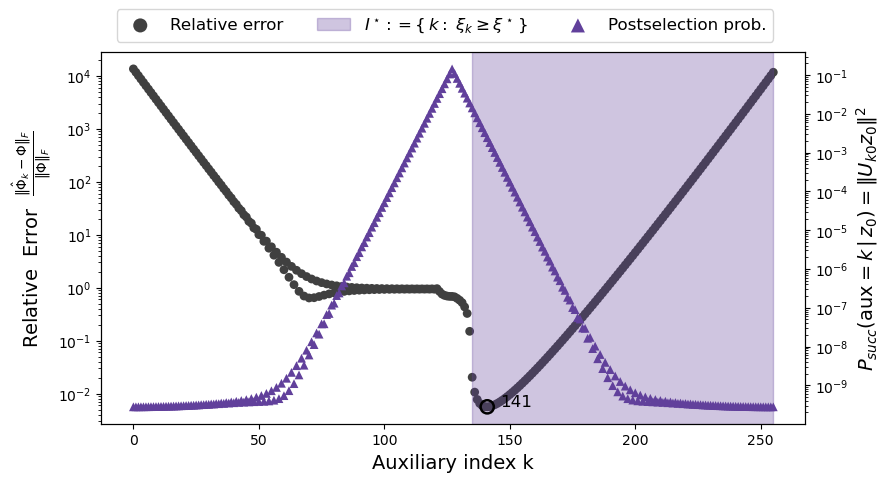

In [26]:
import numpy as np
import matplotlib.pyplot as plt

k_vals = np.arange(N_xi)

fig, ax1 = plt.subplots(figsize=(9, 4.5))

s_small = 40   # tamaño puntos normales (scatter usa área)
s_big   = 90  # tamaño del marcador destacado

# --- Error (izquierda) ---
ax1.scatter(k_vals, errs, s=s_small, marker="o",
             edgecolors="none", label="Relative error", color= plt.get_cmap("Greys")(0.8))
ax1.set_yscale("log")
ax1.set_xlabel("Auxiliary index k", fontsize=14)
ax1.set_ylabel(r"Relative  Error  $\frac{\|\hat\Phi_k-\Phi\|_F}{\|\Phi\|_F}$", fontsize=14)


# sombreado recovery set
if len(I_star) > 0:
    ax1.axvspan(I_star.min(), I_star.max(), alpha=0.3, label=r"$I^\star := \{\,k:\ \xi_k \geq \xi^\star \,\}$", color= plt.get_cmap("Purples")(0.8))

# --- Probabilidad (derecha) ---
ax2 = ax1.twinx()
ax2.scatter(k_vals, probs, s=s_small, marker="^",
             edgecolors="none", label="Postselection prob.", color=plt.get_cmap("Purples")(0.8))
ax2.set_yscale("log")
ax2.set_ylabel(r"$P_{succ}(\mathrm{aux}=k\,|\,z_0)=\|U_{k0}z_0\|^2$", fontsize=14)

# --- Marcar k_best SIN duplicar el punto (contorno vacío) ---
ax1.scatter([k_best], [errs[k_best]], s=s_big, marker="o",
            facecolors="none", edgecolors="k", linewidths=1.8)
ax1.text(k_best + 5, errs[k_best], str(k_best),
         fontsize=12)

#plt.title("Error and postselection probability vs k")

# --- Leyenda horizontal fuera ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2,
           loc="upper center", bbox_to_anchor=(0.5, 1.08),
           ncol=3, frameon=True, fontsize=12,  markerscale=1.6 )

plt.tight_layout()
plt.show()


out = FIG_DIR / f"{run_id}_sch.pdf"
fig.savefig(out, dpi=200)
generated_files.append(out)


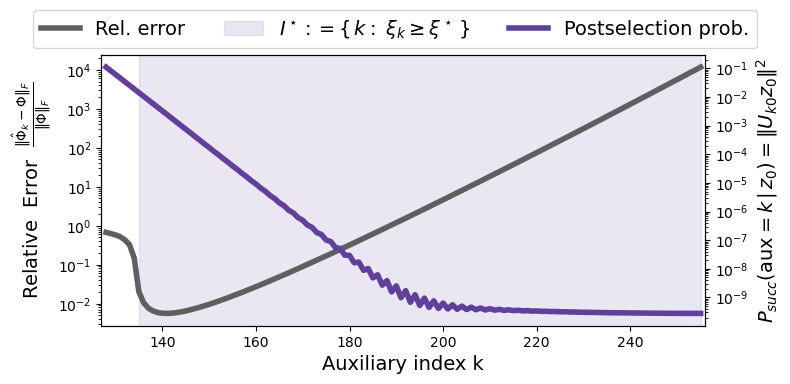

In [27]:
import numpy as np
import matplotlib.pyplot as plt

k_vals = np.arange(N_xi)

# -------------------------------
# 1) Physically correct region
# -------------------------------
mask_phys = xi_grid > 0          # physical: xi > 0

k_phys = k_vals[mask_phys]

fig, ax1 = plt.subplots(figsize=(8, 3.6))

s_small = 40
s_big   = 70

# --- Error (left axis) ---
ax1.plot(k_phys, errs[mask_phys], 
            label="Rel. error",
            color=plt.get_cmap("Greys")(0.7), linewidth=4)

ax1.set_yscale("log")
ax1.set_xlabel("Auxiliary index k", fontsize=14)
ax1.set_ylabel(r"Relative  Error  $\frac{\|\hat\Phi_k-\Phi\|_F}{\|\Phi\|_F}$", fontsize=14)

# -------------------------------
# 2) Recovery set shading (purple)
#    only inside the physical region
# -------------------------------
mask_rec = (xi_grid >= p_star) & mask_phys   # recovery AND physical
k_rec = k_vals[mask_rec]

if k_rec.size > 0:
    ax1.axvspan(k_rec.min(), k_rec.max(),
                alpha=0.15,
                label=r"$I^\star := \{\,k:\ \xi_k \geq \xi^\star \,\}$",
                color=plt.get_cmap("Purples")(0.7))

# --- Probability (right axis) ---
ax2 = ax1.twinx()
ax2.plot(k_phys, probs[mask_phys],
             label="Postselection prob.",
            color=plt.get_cmap("Purples")(0.8), linewidth=4)

ax2.set_yscale("log")
ax2.set_ylabel(r"$P_{succ}(\mathrm{aux}=k\,|\,z_0)=\|U_{k0}z_0\|^2$", fontsize=14)

# # --- Mark k_best only if it's inside the physical region ---
# if mask_phys[k_best]:
#     ax1.scatter([k_best], [errs[k_best]], s=s_big, marker="o",
#                 facecolors="none", edgecolors="k", linewidths=1.8)
#     ax1.text(k_best + 2, errs[k_best], str(k_best), fontsize=12)

# --- Zoom x-axis to physical region ---
ax1.set_xlim(k_phys.min() - 1, k_phys.max() + 1)

# --- Shared legend (top) ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2,
           loc="upper center", bbox_to_anchor=(0.5, 1.08),
           ncol=3, frameon=True, fontsize=14, markerscale=1.6)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # <-- leave space at the top

fig.savefig("myplot.pdf", bbox_inches="tight")

#plt.tight_layout()
plt.show()

from utils.export import *
ROOT = find_repo_root()
FIG_DIR, RES_DIR = ensure_out_dirs(ROOT)
out = FIG_DIR / f"{run_id}_sch.pdf"
fig.savefig(out, dpi=400)
generated_files.append(out)




p_upper = 18.702294 |I| = 121 out of 256
Pr(recover) = 0.05593997960496792
Max error   = 11705.487669211383

p_upper = 18.555032 |I| = 120 out of 256
Pr(recover) = 0.05593997932653574
Max error   = 10104.923687213577

p_upper = 18.407769 |I| = 119 out of 256
Pr(recover) = 0.05593997904810587
Max error   = 8724.599974985053

p_upper = 18.260507 |I| = 118 out of 256
Pr(recover) = 0.05593997876959537
Max error   = 7533.961434243117

p_upper = 18.113245 |I| = 117 out of 256
Pr(recover) = 0.05593997849091492
Max error   = 6506.821220451097

p_upper = 17.965983 |I| = 116 out of 256
Pr(recover) = 0.05593997821198951
Max error   = 5620.577792047478

p_upper = 17.818721 |I| = 115 out of 256
Pr(recover) = 0.05593997793271893
Max error   = 4855.79354602918

p_upper = 17.671459 |I| = 114 out of 256
Pr(recover) = 0.05593997765304046
Max error   = 4195.721499018252

p_upper = 17.524197 |I| = 113 out of 256
Pr(recover) = 0.055939977372836715
Max error   = 3625.9386787805993

p_upper = 17.376934 |I| 

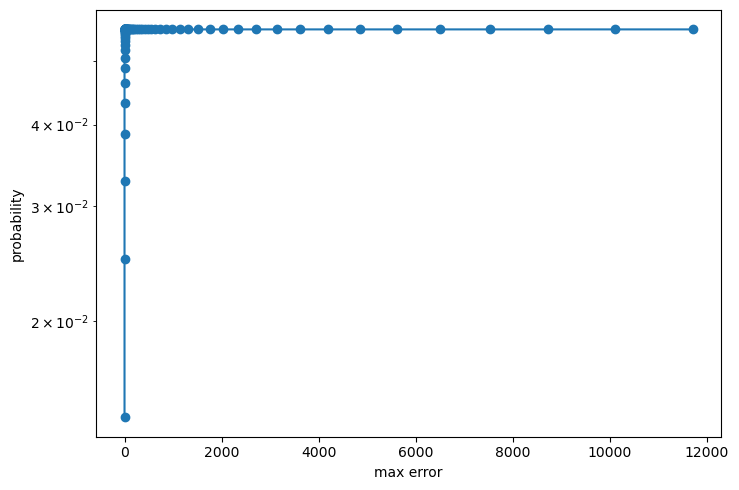

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

# ---- lower fijo ----
lam_max = np.max(np.linalg.eigvalsh(C1))   # C1 Hermitian
p0 = max(0.0, lam_max) * DeltaT            # lower bound fijo

xi   = np.asarray(xi_grid)     # xi_k por cada k
errs = np.asarray(errs)

# probs una sola vez (no dentro del loop)
probs = np.array([norm(U_sch[j*dim:(j+1)*dim, :dim] @ z0)**2 for j in range(N_xi)])

# upper candidates: todos los valores posibles por encima de p0
upper_grid = np.sort(np.unique(xi[xi >= p0]))   # valores posibles de upper
upper_grid = upper_grid[::-1]                   # empezar desde el máximo e ir bajando

prob_recovery = []
max_errors = []
uppers_used = []

for p_upper in upper_grid:
    I = np.where((xi >= p0) & (xi <= p_upper))[0]   # lower fijo, upper decreciente
    
    if I.size == 0:
        continue

    prob_recover = probs[I].sum()
    max_error = errs[I].max()

    uppers_used.append(p_upper)
    prob_recovery.append(prob_recover)
    max_errors.append(max_error)

    print(f"\np_upper = {p_upper:.6f} |I| = {len(I)} out of {N_xi}")
    print("Pr(recover) =", prob_recover)
    print("Max error   =", max_error)

prob_recovery = np.array(prob_recovery)
max_errors    = np.array(max_errors)
uppers_used   = np.array(uppers_used)

# ---- plot trade-off ----
plt.figure(figsize=(7.5, 5))
plt.plot(max_errors, prob_recovery, marker="o", linestyle="-")
plt.yscale("log") 

plt.ylabel("probability")
plt.xlabel("max error")
plt.tight_layout()
plt.show()
